In [1]:
library(tidyverse)
library(ggsci)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_list <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [3]:
matrisome_df <- rutils::load_matrisome_df(matrisome_list) %>%
    dplyr::select(gene_symbol, division, category)
matrisome_genes_df <- matrisome_df %>%
    dplyr::select(gene_symbol)

Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


In [4]:
i <- 1

In [5]:
sig_coxph_res_df <- read_tsv(paste0(dirs$analysis_dir, "/", unified_dsets[i], "_coxph_results.tsv")) %>%
    dplyr::filter(gene_pval < 0.05)

Parsed with column specification:
cols(
  geneID = col_character(),
  gene_pval = col_double(),
  gene_coeff = col_double()
)


In [6]:
deg_res_df <- read_tsv(paste0(dirs$analysis_dir, "/", unified_dsets[i], "_sig_DESeq_results_xref_matrisome.tsv"))

Parsed with column specification:
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  in_matrisome = col_logical(),
  division = col_character(),
  category = col_character(),
  gene_name = col_character(),
  synonyms = col_character(),
  hgnc_ids = col_double(),
  hgnc_ids_links = col_double(),
  uniprot_ids = col_character(),
  refseq_ids = col_character(),
  orthology = col_character(),
  notes = col_character()
)


In [47]:
hm_df <- matrisome_genes_df %>%
    dplyr::rename("geneID" = "gene_symbol") %>%
    mutate(
        DE_only = (geneID %in% deg_res_df$geneID) & !(geneID %in% sig_coxph_res_df$geneID),
        predictive_only = (geneID %in% sig_coxph_res_df$geneID) & !(geneID %in% deg_res_df$geneID),
        both = (geneID %in% sig_coxph_res_df$geneID) & (geneID %in% deg_res_df$geneID),
        neither = !(geneID %in% sig_coxph_res_df$geneID) & !(geneID %in% deg_res_df$geneID)
    )


hm_pivot_df <- hm_df %>%
    pivot_longer(cols = DE_only:neither, names_to = "membership") %>%
    dplyr::filter(value == TRUE) %>%
    dplyr::select(-value) %>%
    mutate(
#         membership_fact = factor(membership, levels = c("neither", "DE_only", "predictive_only", "both")),
        membership_fact = factor(membership, levels = c("both", "predictive_only", "DE_only", "neither")),
        membership_num = as.numeric(membership_fact)
    ) %>%
    dplyr::select(-membership) %>%
    dplyr::rename(membership = membership_fact) %>%
    dplyr::mutate(dummy = "dummy")


Saving 6.67 x 6.67 in image


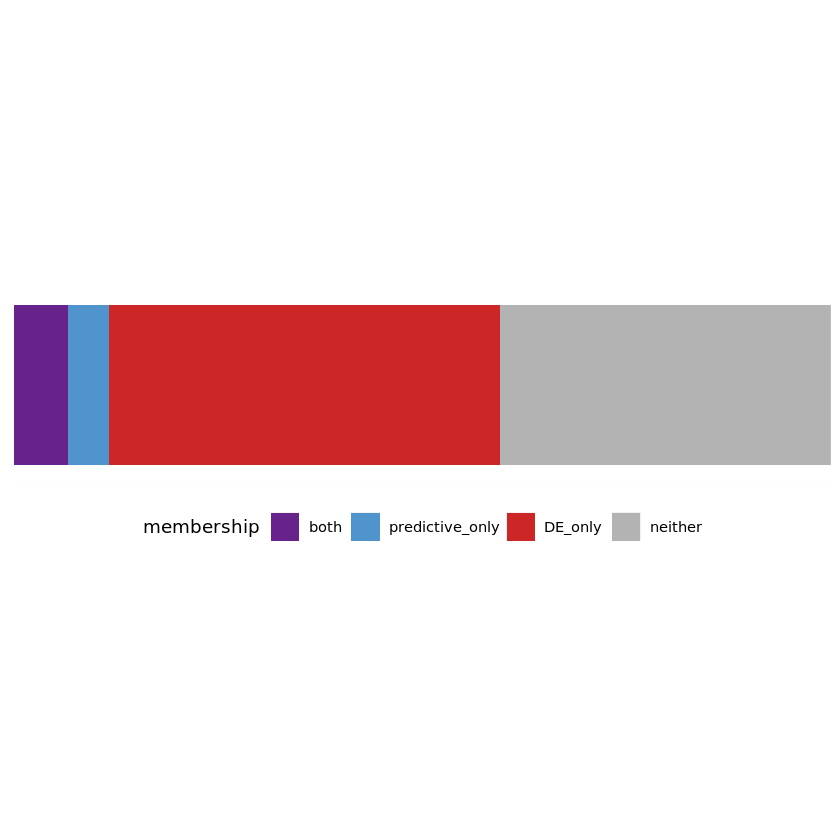

In [58]:
ggplot() +
    geom_tile(aes(y = dummy, x = reorder(geneID, membership_num), fill = membership), data = hm_pivot_df, width = 1) +
    scale_fill_manual(values = rev(c("gray70", "firebrick3", "steelblue3", "darkorchid4"))) +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        legend.position = "bottom"
    ) +
    coord_equal(ratio = 200)
ggsave(paste0(dirs$figures_dir, "/", unified_dsets[i], "_matrisome_DEG_predictive_horizontal_hm.png"), last_plot())

In [83]:
# bp_df <- matrisome_genes_df %>%
#     dplyr::rename("geneID" = "gene_symbol") %>%
#     mutate(
#         DE = geneID %in% deg_res_df$geneID,
#         predictive = geneID %in% sig_coxph_res_df$geneID,
#         both = DE & predictive,
#         neither = !(DE | predictive)
#     )

# bp_pivot_df <- bp_df %>%
#     pivot_longer(cols = DE:neither, names_to = "membership") %>%
#     dplyr::filter(value == TRUE) %>%
#     dplyr::select(-value) %>%
#     mutate(
#         membership_fact = factor(membership, levels = c("both", "predictive", "DE", "neither")),
#         membership_num = as.numeric(membership_fact)
#     ) %>%
#     dplyr::select(-membership) %>%
#     dplyr::rename(membership = membership_fact)

bp_pivot_df <- hm_df %>%
    pivot_longer(cols = DE_only:neither, names_to = "membership") %>%
    dplyr::filter(value == TRUE) %>%
    dplyr::select(-value) %>%
    mutate(
        membership_fact = factor(membership, levels = c("both", "predictive_only", "DE_only", "neither")),
        membership_num = as.numeric(membership_fact)
    ) %>%
    dplyr::select(-membership) %>%
    dplyr::rename(membership = membership_fact)

In [84]:
cat_bp_df <- bp_pivot_df %>%
    inner_join(matrisome_df, by = c("geneID" = "gene_symbol")) %>%
    group_by(category, membership) %>%
    summarize(n_genes = n())
cat_bp_df

`summarise()` regrouping output by 'category' (override with `.groups` argument)


category,membership,n_genes
<chr>,<fct>,<int>
Collagens,both,3
Collagens,DE_only,25
Collagens,neither,16
ECM Glycoproteins,both,12
ECM Glycoproteins,predictive_only,13
ECM Glycoproteins,DE_only,101
ECM Glycoproteins,neither,69
ECM Regulators,both,17
ECM Regulators,predictive_only,15


Saving 6.67 x 6.67 in image


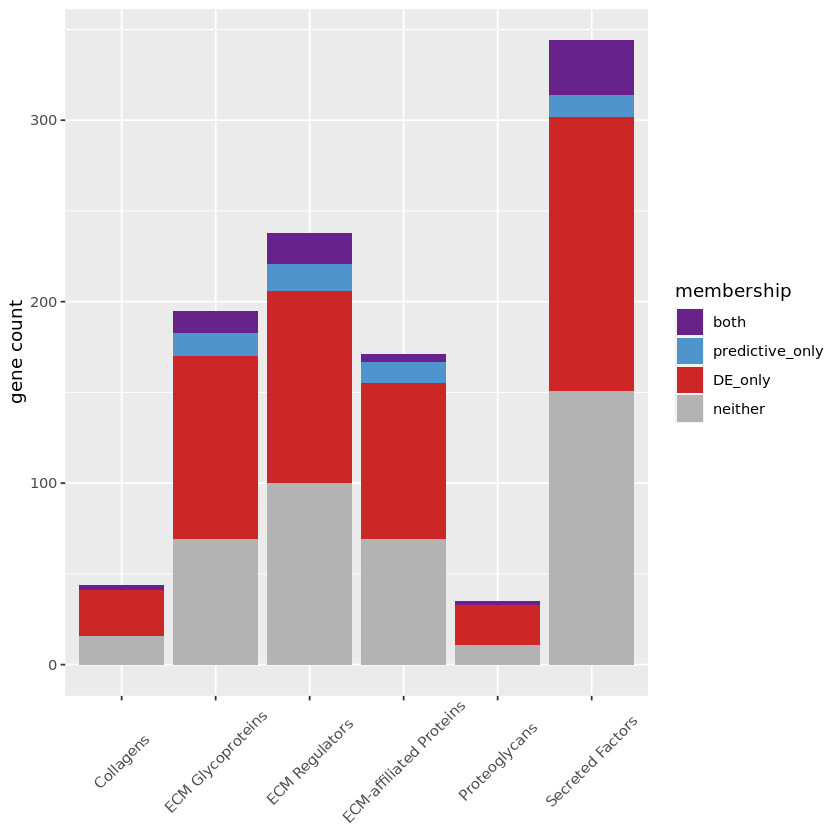

In [85]:
# ggplot(data = cat_bp_df, aes(x = membership, y = n_genes, fill = category)) +
ggplot(data = cat_bp_df, aes(x = category, y = n_genes, fill = membership)) +
#     scale_fill_jama() +
    scale_fill_manual(values = rev(c("gray70", "firebrick3", "steelblue3", "darkorchid4"))) +
    labs(y = "gene count") +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle = 45, vjust = 0.55, hjust=0.5)
    ) +
    geom_bar(stat = "identity")
ggsave(paste0(dirs$figures_dir, "/", unified_dsets[i], "_matrisome_DEG_predictive_stacked_bp.png"), last_plot())